In [1]:
# Download and extract data
!wget https://huggingface.co/datasets/dim/SemEvalSubtask2/resolve/main/training_data/all_videos_and_audios.tar.gz?download=true -O all_videos_and_audios.tar.gz
!tar -xf all_videos_and_audios.tar.gz


--2024-10-17 21:27:43--  https://huggingface.co/datasets/dim/SemEvalSubtask2/resolve/main/training_data/all_videos_and_audios.tar.gz?download=true
Resolving huggingface.co (huggingface.co)... 18.160.143.75, 18.160.143.99, 18.160.143.32, ...
Connecting to huggingface.co (huggingface.co)|18.160.143.75|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/bc/1d/bc1d3a3f695e1279fa7b4ae4f9799c59e08609b600b8d69bf962eb749818ffa8/ba6bec9a4c5d56de62d8ca9341a8a8a401e5b6d86f73a5ed118b97842e8566e0?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27all_videos_and_audios.tar.gz%3B+filename%3D%22all_videos_and_audios.tar.gz%22%3B&response-content-type=application%2Fgzip&Expires=1729459663&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyOTQ1OTY2M319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2JjLzFkL2JjMWQzYTNmNjk1ZTEyNzlmYTdiNGFlNGY5Nzk5YzU5ZTA4NjA5YjYwMGI4ZDY5YmY5NjJlY

In [2]:
!wget https://huggingface.co/datasets/dim/SemEvalSubtask2/resolve/main/training_data/Subtask_2_train.json?download=true -O train.json


--2024-10-17 21:34:37--  https://huggingface.co/datasets/dim/SemEvalSubtask2/resolve/main/training_data/Subtask_2_train.json?download=true
Resolving huggingface.co (huggingface.co)... 18.160.143.32, 18.160.143.76, 18.160.143.75, ...
Connecting to huggingface.co (huggingface.co)|18.160.143.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4451198 (4.2M) [text/plain]
Saving to: ‘train.json’

train.json          100%[===================>]   4.24M  19.7MB/s    in 0.2s    

2024-10-17 21:34:38 (19.7 MB/s) - ‘train.json’ saved [4451198/4451198]



In [3]:
# Import necessary libraries
import os
import json
import cv2
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


# Load training data
with open("train.json", "r") as f:
    train_data = json.load(f)

# Display a sample video
from base64 import b64encode
from IPython.display import HTML

def show_video(video_path, video_width=600):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

rnd = np.random.randint(0, len(train_data))
video_path = 'train/' + train_data[rnd]['conversation'][0]['video_name']

print(train_data[rnd]['conversation'][0]['text'])
show_video(video_path)

and then , we could have gone from the ceremony to the reception with you in the sidecar !


In [8]:
# Define a mapping from emotion strings to numerical labels (modify according to your dataset)
emotion_mapping = {
    "happy": 0,
    "sad": 1,
    "angry": 2,
    "surprised": 3,
    "joy": 3,
    "disgust": 3,
    "neutral": 4
}

class VideoDataset(Dataset):
    def __init__(self, video_dir, annotations, transform=None):
        self.video_dir = video_dir
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def load_video(self, video_path):
        """Loads video from a given path and returns frames as tensors"""
        frames = []
        cap = cv2.VideoCapture(video_path)
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)
        cap.release()

        frames = torch.stack(frames)  # Shape: [time, channels, height, width]
        frames = frames.permute(1, 0, 2, 3)  # Change to [channels, time, height, width]
        return frames

    def __getitem__(self, idx):
        video_info = self.annotations[idx]['conversation'][0]
        video_path = os.path.join(self.video_dir, video_info['video_name'])

        # Load the video
        video = self.load_video(video_path)

        # Convert the emotion string to a numerical label using the mapping
        emotion_str = video_info.get('emotion', 'neutral')
        emotion = emotion_mapping.get(emotion_str, 4)

        return video, torch.tensor(emotion)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
])


In [9]:
# Initialize dataset and dataloader
video_dir = "train"
dataset = VideoDataset(video_dir=video_dir, annotations=train_data, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# 3D CNN Model Definition for Feature Extraction
class FeatureExtractor3DCNN(nn.Module):
    def __init__(self):
        super(FeatureExtractor3DCNN, self).__init__()

        self.model = r3d_18(weights="R3D_18_Weights.DEFAULT")

        self.model = nn.Sequential(*list(self.model.children())[:-1])

    def forward(self, x):
        with torch.no_grad():
            x = self.model(x)
        return x

# Initialize the model and set it to evaluation mode
model = FeatureExtractor3DCNN()
model.eval()

# Get one batch of video data
video_tensor, emotion = next(iter(dataloader))

# Display shape of the input video tensor
print(f"Input video tensor shape: {video_tensor.shape}")

# Pass the video through the 3D CNN model to extract features (embeddings)
video_embedding = model(video_tensor)

# The output embedding will be in the shape [batch_size, 512, 1, 1, 1], squeeze to [batch_size, 512]
video_embedding = video_embedding.squeeze()
print(f"Extracted video embedding shape: {video_embedding.shape}")


Input video tensor shape: torch.Size([1, 3, 63, 112, 112])
Extracted video embedding shape: torch.Size([512])


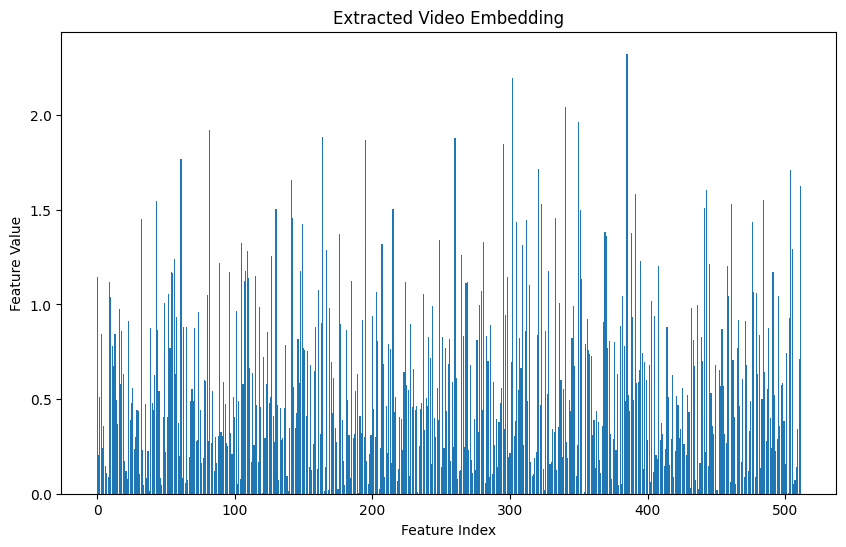

In [10]:
# Visualize the extracted features
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(range(video_embedding.shape[0]), video_embedding.cpu().numpy())  # Plot the embedding as a bar plot
plt.title("Extracted Video Embedding")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.show()
